# Apply model regression, conditioning out pH

That is, a seperate regression on each column of data. 

And/or, a regression incorporating pH data explicitly, and seperatly an only pH regression.

In [1]:
import os, sys
import time
import csv
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning

from mgsa.io import samples_from_soils, get_function, get_data
from mgsa.modeling import Model

In [2]:
NARG_INFO = {
    "KO": "K00370",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00370_v1.tsv"
}

NIRB_INFO = {
    "KO": "K00362",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00362_v1.tsv"
}

NATIVE_IDXS = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
NATIVE_PHS = np.array([5.0, 5.3, 5.41, 5.8, 6.15, 6.3, 6.5, 6.75, 6.9,  7.1])
PERTURBED_PHS = np.linspace(3.8, 8.4, 11)

OUTDIR = "../out/model_regression/nar"
IMGDIR = f"{OUTDIR}/images"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(IMGDIR, exist_ok=True)

def texify(param_name):
    return {
        "gamma_A": "\\gamma_{{A}}", 
        "gamma_I": "\\gamma_{{I}}", 
        "r_A": "r_{{A}}", 
        "r_I1": "r_{{I1}}", 
        "r_I2": "r_{{I2}}", 
        "K_A": "K_{{A}}", 
        "K_I": "K_{{I}}", 
        "mu": "\\mu", 
    }[param_name]

In [3]:
# Final 3 points will be for fitting the enzyme
t_data = np.linspace(0, 22, 23)

# For the drug data, we only want to fit the Nitrate and Nitrite curves
t_data_drug = np.linspace(0, 19, 20)

soils = [
    'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 
    'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'
]

nar_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00370.tsv', sep='\t', header=None,
).values
nar_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_None.tsv', sep='\t', header=None,
).values
nar_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_CHL.tsv', sep='\t', header=None,
).values

nir_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00362.tsv', sep='\t', header=None,
).values
nir_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_None.tsv', sep='\t', header=None,
).values
nir_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_CHL.tsv', sep='\t', header=None,
).values

nit_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K17877.tsv', sep='\t', header=None,
).values
nit_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_None.tsv', sep='\t', header=None,
).values
nit_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_CHL.tsv', sep='\t', header=None,
).values

In [6]:
##############################################################################
### Define the ODE and Model(s)

def RHS(y, params):
    x1, x2, x3, A, I = y
    gamma_A = params['gamma_A']
    gamma_I = params['gamma_I']
    r_A = params['r_A']
    r_I1 = params['r_I1']
    r_I2 = params['r_I2']
    K_A = params['K_A']
    K_I = params['K_I']
    mu = params['mu']

    A = max(A, 1e-10)
    I = max(I, 1e-10)
    alpha = gamma_A*r_A*A/(K_A + A)*x1 + gamma_I*I/(K_I + I)*(r_I1*x2 + r_I2*x3)
    xi_1_temp = gamma_A*r_A*A
    xi_2_temp = gamma_I*r_I1*I
    xi_3_temp = gamma_I*r_I2*I
    xi_1 = xi_1_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_2 = xi_2_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_3 = xi_3_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    dx1 = xi_1*alpha - mu*x1
    dx2 = xi_2*alpha - mu*x2
    dx3 = xi_3*alpha/2 - mu*x3
    dA = -r_A*x1*A/(K_A + A)
    dI = r_A*x1*A/(K_A + A) - (I/(K_I + I))*(r_I1*x2 + r_I2*x3)

    dydt = np.array([dx1, dx2, dx3, dA, dI])
    return dydt


##############################################################################
### Ordered parameters: [gamma_A, gamma_I, r_A, r_I1, r_I2, K_A, K_I, mu]

PARAM_NAMES = ["gamma_A", "gamma_I", "r_A", "r_I1", "r_I2", "K_A", "K_I", "mu"]

# Fixed parameters
K_A = 0.1
K_I = 0.1
mu_chl_pos = 0.0
mu_chl_neg = 0.3

FIXED_PARAMS_CHL_POS = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_pos,
    "gamma_A": 0.,
    "gamma_I": 0.,
    "r_I2": 0.,
}
FIXED_PARAMS_CHL_NEG = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_neg,
}


##############################################################################
### Construct the CHL+ and CHL- models

MODEL_CHL_POS = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_POS,
)

MODEL_CHL_NEG = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_NEG,
)

print("CHL+ Model:\n", MODEL_CHL_POS)
print("CHL- Model:\n", MODEL_CHL_NEG)


CHL+ Model:
 Model [num_params=8, num_inferred=2]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.0, 'gamma_A': 0.0, 'gamma_I': 0.0, 'r_I2': 0.0}
CHL- Model:
 Model [num_params=8, num_inferred=5]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.3}


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

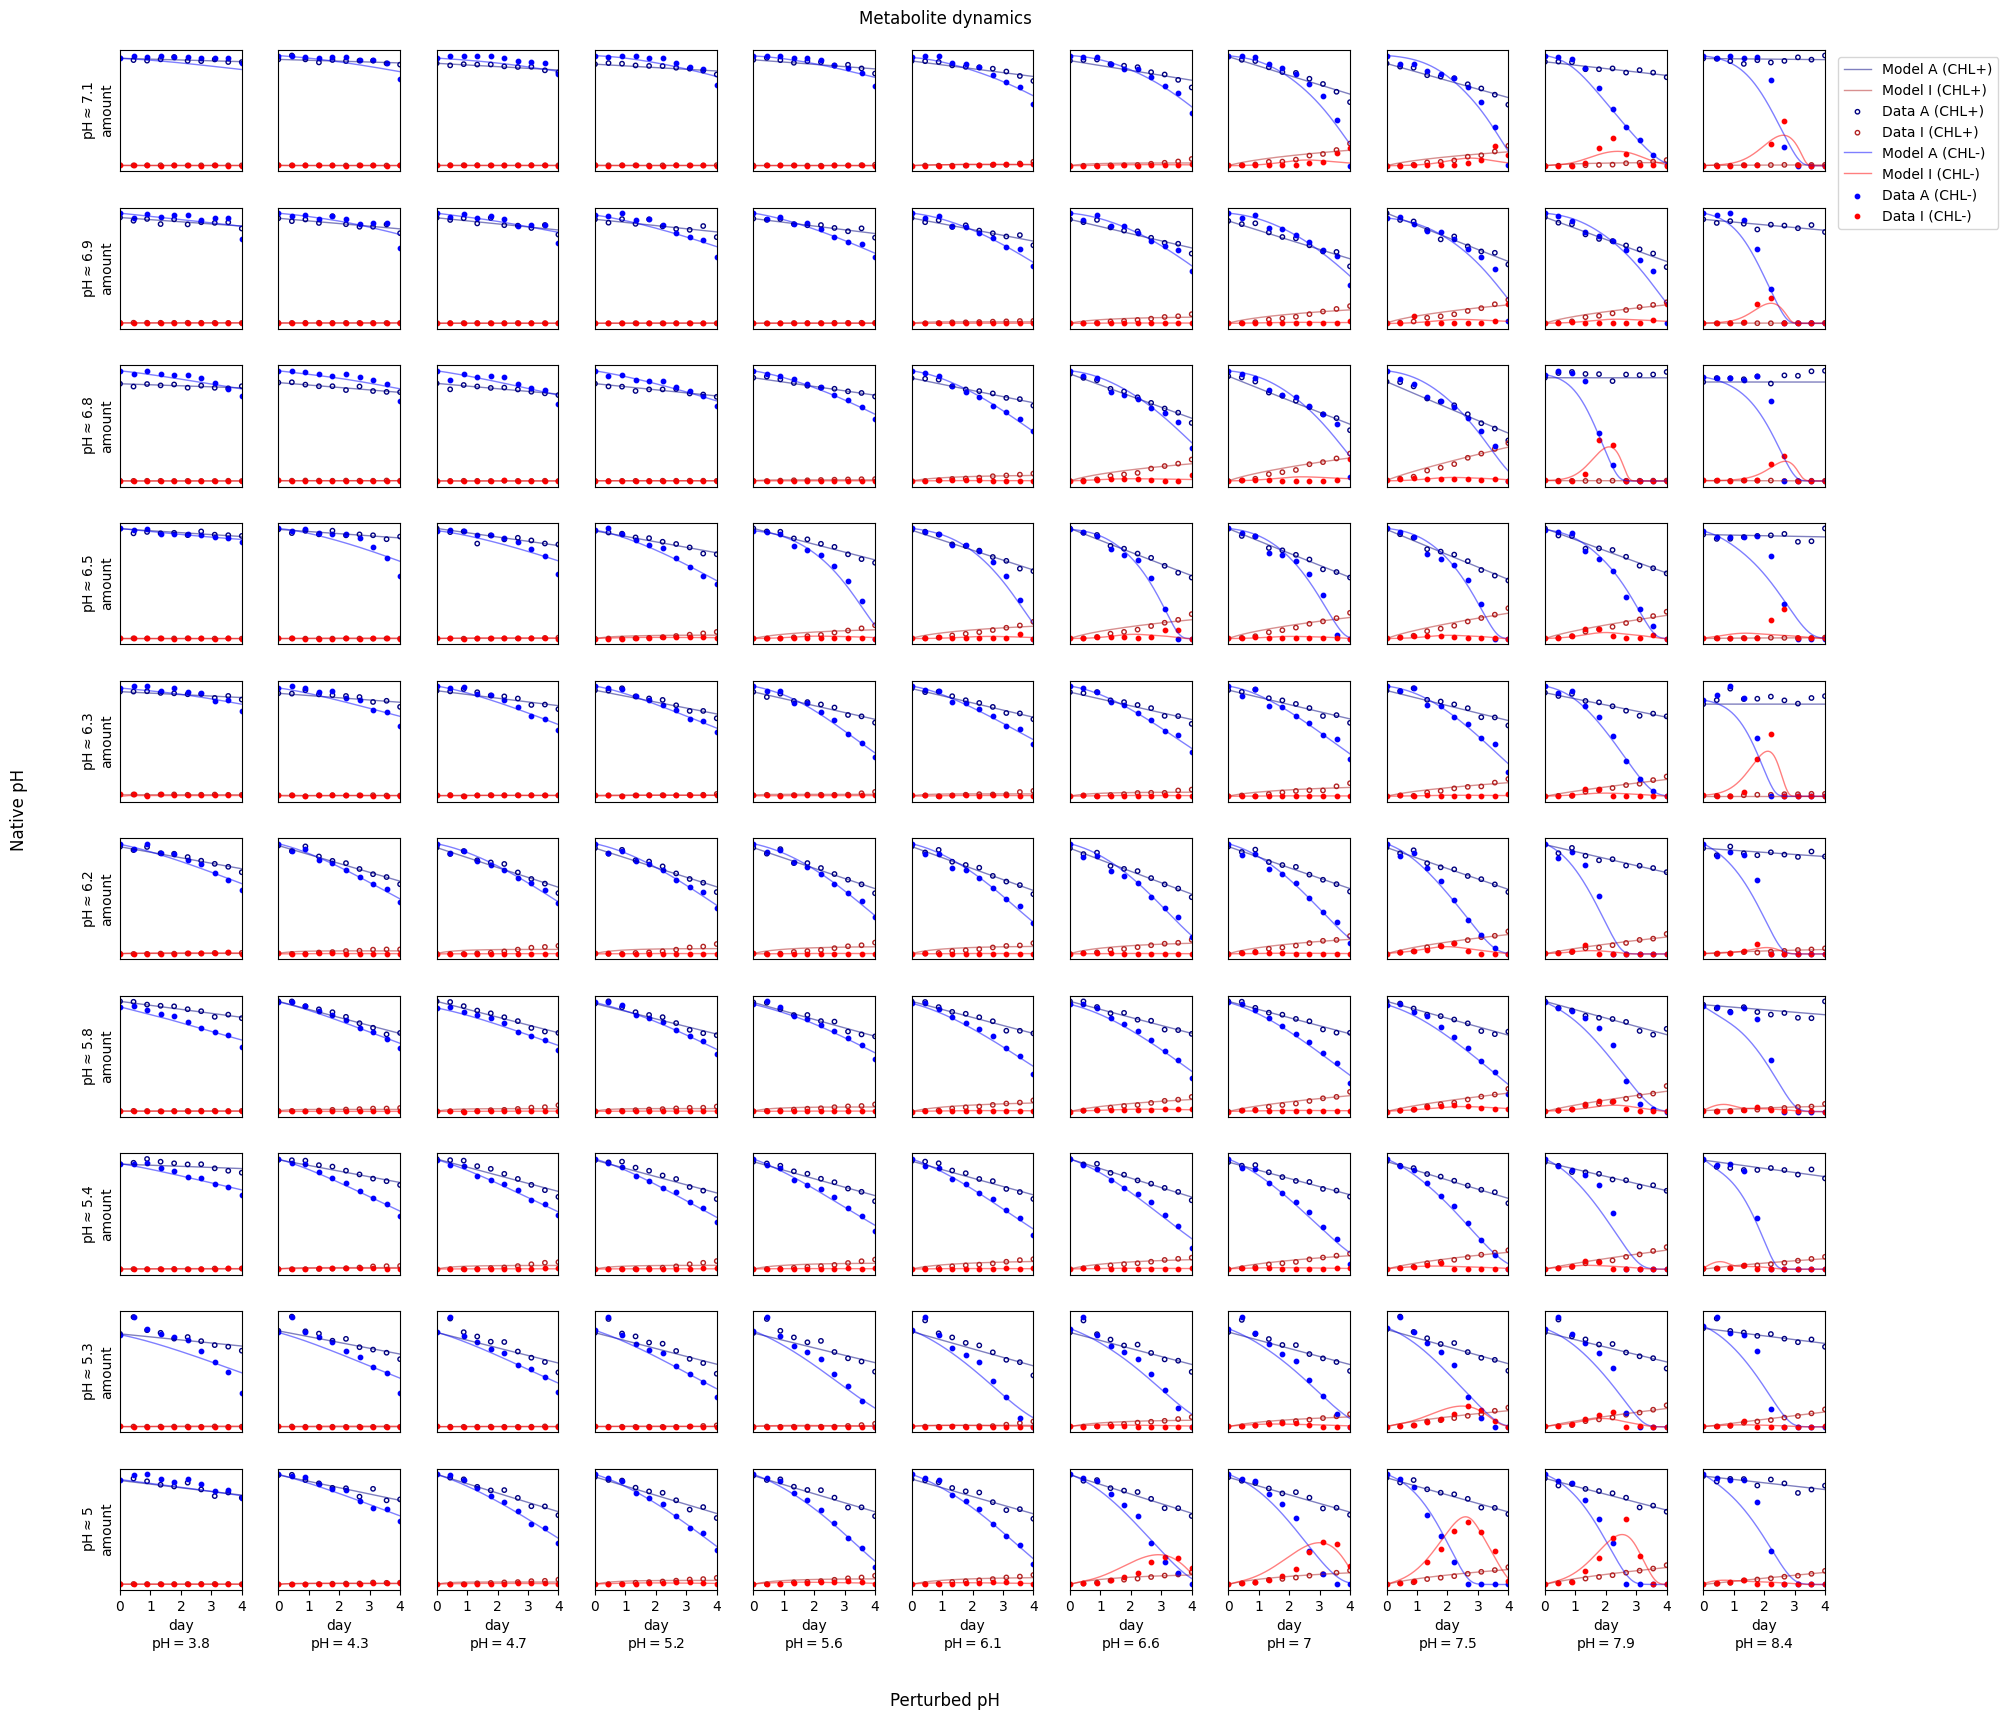

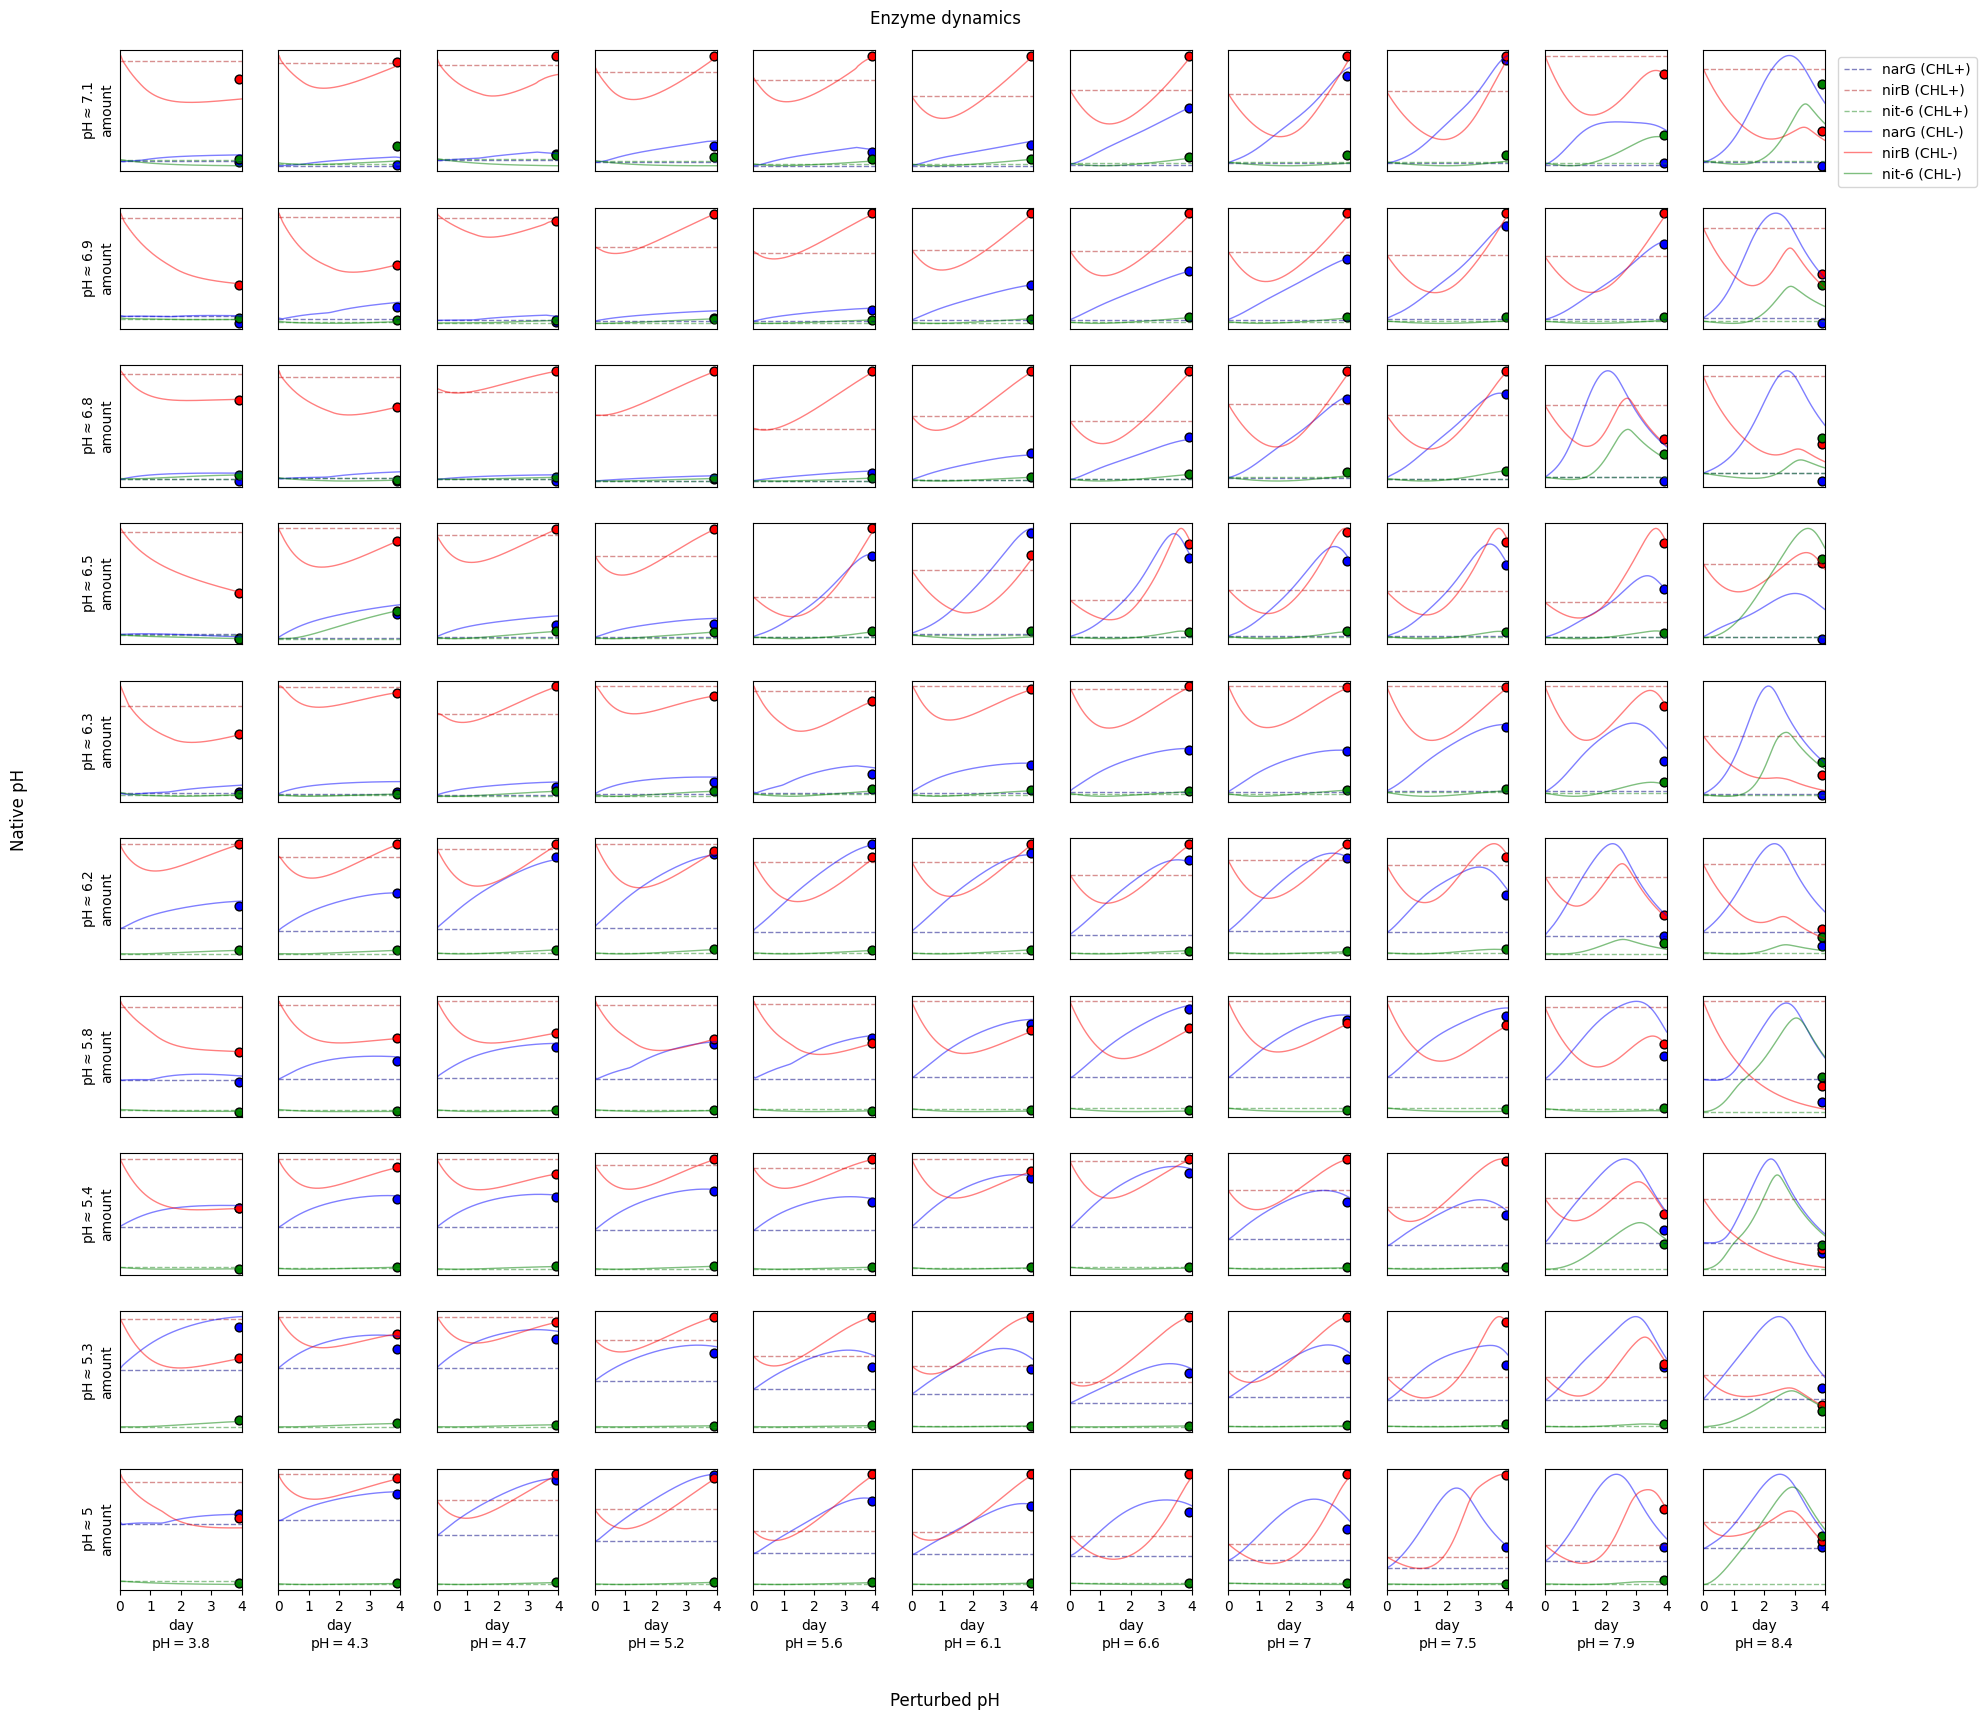

In [7]:
DO_PLOT = True

if DO_PLOT:
    fig_metabs, axs_metabs = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig_enzyme, axs_enzymes = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


# Specify a weighting where the biomass points 'matter more' when computing the 
# curve fit. We want to force it to pick parameters so that these enzyme curves 
# do what is expected of them.
sigma = np.ones(23)
sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
inferred_params_chl_pos = np.nan * np.ones([10, 11, 2])
inferred_params_chl_neg = np.nan * np.ones([10, 11, 5])
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)
for native in tqdm.trange(10, desc="native"):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        
        # Scaled initial and final enzyme levels
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[9 - native, pert]/scale
        x1_f = nar_t9_none[9 - native, pert]/scale
        x2_f = nir_t9_none[9 - native, pert]/scale
        x3_f = nit_t9_none[9 - native, pert]/scale
        
        # Collect soil samples for the native/perturbed sample
        sample = samples_from_soils(soils[9 - native])[pert]        
        
        # Load functional data for the CHL+ case
        function = get_function(sample, drug='CHL')
        A_data_drug = np.mean(function[0:3,:], axis=0)
        I_data_drug = np.mean(function[3:,:], axis=0)
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        # Load functional data for the CHL- case, appending final enzyme levels
        function = get_function(sample)
        A_data = np.mean(function[0:3,:], axis=0)
        I_data = np.mean(function[3:,:], axis=0)
        y_data = np.concatenate([A_data, I_data, [x1_f, x2_f, x3_f]])
        
        # Fit model (CHL+)
        y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
        def model_drug(t, r_A, r_I):
            params = {"r_A": r_A, "r_I1": r_I}
            _, _, _, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = (
            [0.001, 0.001], 
            [10, 10],
        )
        popt, pcov = curve_fit(
            model_drug, t_data_drug, y_data_drug, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=100000,
        )
        inferred_params_chl_pos[native, pert, :] = popt

        if DO_PLOT:
            # Plot the inferred model (CHL+)
            params = {"r_A": popt[0], "r_I1": popt[1]}
            x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)

            axtitle = ", ".join(
                [f"${texify(p)}={popt[i]:.2g}$" 
                 for i, p in enumerate(MODEL_CHL_POS.get_inferred_param_names())]
            )
            
            # Plot metabolites (CHL+)
            ax = axs_metabs[native, pert]
            ax.plot(
                plot_t, A, 
                color='navy', alpha=0.5, linewidth=1, 
                label="Model A (CHL+)"
            )
            ax.plot(
                plot_t, I, 
                color='firebrick', alpha=0.5, linewidth=1,
                label="Model I (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, A_data_drug, 
                color='navy', s=10, facecolors='none',
                label="Data A (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, I_data_drug, 
                color='firebrick', s=10, facecolors='none',
                label="Data I (CHL+)"
            )
            
            # Plot enzymes (CHL+)
            ax = axs_enzymes[native, pert]
            ax.plot(
                plot_t, x1, 
                color='navy', alpha=0.5, linewidth=1, linestyle='--',
                label="narG (CHL+)"
            )
            ax.plot(
                plot_t, x2, 
                color='firebrick', alpha=0.5, linewidth=1, linestyle='--',
                label="nirB (CHL+)"
            )
            ax.plot(
                plot_t, x3, 
                color='forestgreen', alpha=0.5, linewidth=1, linestyle='--',
                label="nit-6 (CHL+)"
            )
        
        # Fit model (CHL-)
        y0 = np.array([x1_0, x2_0, x3_0, A_data[0], I_data[0]])
        def model(t, gamma_A, gamma_I, r_A, r_I1, r_I2):
            params = {
                "gamma_A": gamma_A, "gamma_I": gamma_I, 
                "r_A": r_A, "r_I1": r_I1, "r_I2": r_I2
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            y_out = np.concatenate([A_out, I_out, [x1[-1], x2[-1], x3[-1]]])
            return y_out
        
        initial_guess = [2, 1, 0.01, 0.1, 0.1]
        bounds = (
            [0.001, 0.001, 0.0001, 0.0001, 0.0001], 
            [10, 10, 10, 10, 10],
        )
        
        popt, pcov = curve_fit(
            model, t_data, y_data, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=10000,
            sigma=sigma,
        )
        
        inferred_params_chl_neg[native, pert, :] = popt
        
        if DO_PLOT:
            # Plot the inferred model (CHL-)
            params = {
                "gamma_A": popt[0], "gamma_I": popt[1], 
                "r_A": popt[2], "r_I1": popt[3], "r_I2": popt[4]
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
        
            # Plot metabolites (CHL-)
            ax = axs_metabs[native, pert]
            ax.plot(
                plot_t, A, color='Blue', alpha=0.5, linewidth=1,
                label="Model A (CHL-)"
            )
            ax.plot(
                plot_t, I, color='Red', alpha=0.5, linewidth=1,
                label="Model I (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, A_data, color='Blue', s=10, 
                label="Data A (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, I_data, color='Red', s=10, 
                label="Data I (CHL-)"
            )
            
            # Plot enzymes (CHL-)
            ax = axs_enzymes[native, pert]
            ax.plot(
                plot_t, x1, color='Blue', alpha=0.5, linewidth=1,
                label="narG (CHL-)"
            )
            ax.plot(
                plot_t, x2, color='Red', alpha=0.5, linewidth=1,
                label="nirB (CHL-)"
            )
            ax.plot(
                plot_t, x3, color='Green', alpha = 0.5, linewidth=1,
                label="nit-6 (CHL-)"
            )
            ax.scatter(
                8.8, x1_f, 
                color='Blue', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            ax.scatter(
                8.8, x2_f, 
                color='Red', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            sc = ax.scatter(
                8.8, x3_f, 
                color='Green', s=40, edgecolors='black', linewidths=1,
                label=""
            )

            for ax in [axs_metabs[native, pert], axs_enzymes[native, pert]]:
                ax.set_xlim(0, 9)
                ax.set_yticks([])
                if native == 0 and pert == 10:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                if pert == 0:
                    ax.set_ylabel(f"pH$\\approx${NATIVE_PHS[9 - native]:.2g}\namount")
                if native == 9:
                    ax.set_xticks(
                        np.linspace(0, 9, 5, endpoint=True), 
                        labels=[str(i) for i in range(5)]
                    )
                    ax.set_xlabel(f"day\npH$=${PERTURBED_PHS[pert]:.2g}")
                else:
                    ax.set_xticks([])

if DO_PLOT:
    title = "Metabolite dynamics"
    subtitle = ""
    fig_metabs.supxlabel("Perturbed pH", y=0.05)
    fig_metabs.supylabel("Native pH", x=0.075)
    fig_metabs.suptitle(
        title + "\n" + subtitle if subtitle else title, 
        y=0.90
    )

    title = "Enzyme dynamics"
    subtitle = ""
    fig_enzyme.supxlabel("Perturbed pH", y=0.05)
    fig_enzyme.supylabel("Native pH", x=0.075)
    fig_enzyme.suptitle(
        title + "\n" + subtitle if subtitle else title, 
        y=0.90
    )

    plt.figure(fig_metabs)
    plt.savefig(f"{IMGDIR}/model_vs_data_metabolites.png")
    plt.figure(fig_enzyme)
    plt.savefig(f"{IMGDIR}/model_vs_data_enzymes.png")
    plt.show()

In [9]:
def load_orf_groups(fpath) -> tuple[dict[int:str], np.ndarray[int]]:
    groups = {}
    idxs = []
    with open(fpath, "r") as f:
        csvreader = csv.reader(f, delimiter=" ")
        for row in csvreader:  # process each row
            orf = row[0]
            gidx = int(row[1])
            if gidx in groups:
                groups[gidx].append(orf)
            else:
                groups[gidx] = [orf]
                idxs.append(gidx)
    return groups, np.sort(idxs)

In [106]:
##############################################################################
##  Collect narG data

# Load ORF groups for narG
groups, group_idxs = load_orf_groups(NARG_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nar_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nar_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nar_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nar_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nar_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nar_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]

##############################################################################
##  Collect nirB data

# Load ORF groups for nirB
groups, group_idxs = load_orf_groups(NIRB_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nir_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nir_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nir_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nir_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nir_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nir_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]


Group 1: 14 ORFs
Group 2: 4 ORFs
Group 3: 4 ORFs
Group 4: 8 ORFs
Group 5: 6 ORFs
Group 6: 6 ORFs
Group 7: 15 ORFs
  Total: 57
Group 1: 6 ORFs
Group 2: 19 ORFs
Group 3: 8 ORFs
Group 4: 6 ORFs
Group 5: 10 ORFs
Group 6: 7 ORFs
Group 7: 6 ORFs
  Total: 62


In [107]:
##############################################################################
##  Normalize narG expression levels
nar_rel_exp_chl_pos_t0 = nar_exp_chl_pos_t0 / np.sum(nar_exp_chl_pos_t0, -1)[...,None]
nar_rel_exp_chl_pos_t0 = nar_rel_exp_chl_pos_t0[:, np.newaxis, :]
nar_rel_exp_chl_pos_t0 = np.broadcast_to(nar_rel_exp_chl_pos_t0, (10, 11, 7))

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_pos_t0 = nir_exp_chl_pos_t0 / np.sum(nir_exp_chl_pos_t0, -1)[...,None]
nir_rel_exp_chl_pos_t0 = nir_rel_exp_chl_pos_t0[:, np.newaxis, :]
nir_rel_exp_chl_pos_t0 = np.broadcast_to(nir_rel_exp_chl_pos_t0, (10, 11, 7))



In [108]:
##Introduce and reshape pH

from mgsa.io import perturbed_pHs
pH = np.zeros((10, 11))
for i, row in enumerate(pH):
    row += perturbed_pHs(soils[i])
pH_grid = pH 
print(pH_grid.shape)
pH = pH[..., np.newaxis] 
pH = pH.reshape([-1, pH.shape[-1]])
print(pH.shape)

(10, 11)
(110, 1)


In [133]:
print(f"narG Expression (CHL+) shape: {nar_rel_exp_chl_pos_t0.shape}")
print(f"nirB Expression (CHL+) shape: {nir_rel_exp_chl_pos_t0.shape}")
print(f"Parameters (CHL+) shape: {inferred_params_chl_pos.shape}")
print(f"Parameters (CHL-) shape: {inferred_params_chl_neg.shape}")

print("Reshaping and concatenating...")
X_NAR_CHL_POS = nar_rel_exp_chl_pos_t0.reshape([-1, nar_rel_exp_chl_pos_t0.shape[-1]])
X_NIR_CHL_POS = nir_rel_exp_chl_pos_t0.reshape([-1, nir_rel_exp_chl_pos_t0.shape[-1]])
Y_CHL_POS = inferred_params_chl_pos.reshape([-1, inferred_params_chl_pos.shape[-1]])
X_NAR_CHL_POS = np.concatenate([X_NAR_CHL_POS, pH], axis=-1) 
X_NIR_CHL_POS = np.concatenate([X_NIR_CHL_POS, pH], axis=-1) 

print(f"X nar (CHL+) shape: {X_NAR_CHL_POS.shape}")
print(f"X nir (CHL+) shape: {X_NIR_CHL_POS.shape}")
print(f"Y (CHL+) shape: {Y_CHL_POS.shape}")

narG Expression (CHL+) shape: (10, 11, 7)
nirB Expression (CHL+) shape: (10, 11, 7)
Parameters (CHL+) shape: (10, 11, 2)
Parameters (CHL-) shape: (10, 11, 5)
Reshaping and concatenating...
X nar (CHL+) shape: (110, 8)
X nir (CHL+) shape: (110, 8)
Y (CHL+) shape: (110, 2)


Let's only use T0 for CHL+ (for now?)

In [110]:
##############################################################################
### Lasso for NAR CHL+ case

X = X_NAR_CHL_POS
Y = Y_CHL_POS[:,0]

ALPHA = 0.001  # Regularization strength

clf_nar = linear_model.Lasso(alpha=ALPHA)
clf_nar.fit(X, Y)

print("--------------------------------------------------")
print("CHL+")
print(f"Coefficients {clf_nar.coef_.shape}:\n", clf_nar.coef_)
print(f"Intercepts: {clf_nar.intercept_.shape}\n", clf_nar.intercept_)
print("--------------------------------------------------")

##############################################################################
### Lasso for NIR CHL-

X = X_NIR_CHL_POS
Y = Y_CHL_POS[:,1]

ALPHA = 0.001  # Regularization strength

clf_nir = linear_model.Lasso(alpha=ALPHA)
clf_nir.fit(X, Y)

print("--------------------------------------------------")
print("CHL-")
print(f"Coefficients {clf_nir.coef_.shape}:\n", clf_nir.coef_)
print(f"Intercepts: {clf_nir.intercept_.shape}\n", clf_nir.intercept_)
print("--------------------------------------------------")

--------------------------------------------------
CHL+
Coefficients (8,):
 [-0.51949429  0.          0.06804651  0.11699932  0.          0.
 -0.12077671  0.05774201]
Intercepts: ()
 0.29597792370968573
--------------------------------------------------
--------------------------------------------------
CHL-
Coefficients (8,):
 [-2.0478784  -0.          0.          0.69772166 -0.         -0.64879604
  1.14850277 -0.1272607 ]
Intercepts: ()
 1.0649642683819955
--------------------------------------------------


In [101]:
print(len(clf_nar.coef_))
print(pH.shape)

8
(110, 1)


In [ ]:
print(nir_rel_exp_chl_pos_t0.shape)
X_NIR = nir_rel_exp_chl_pos_t0
X_NAR = nar_rel_exp_chl_pos_t0

(10, 11, 7)


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'coef_'

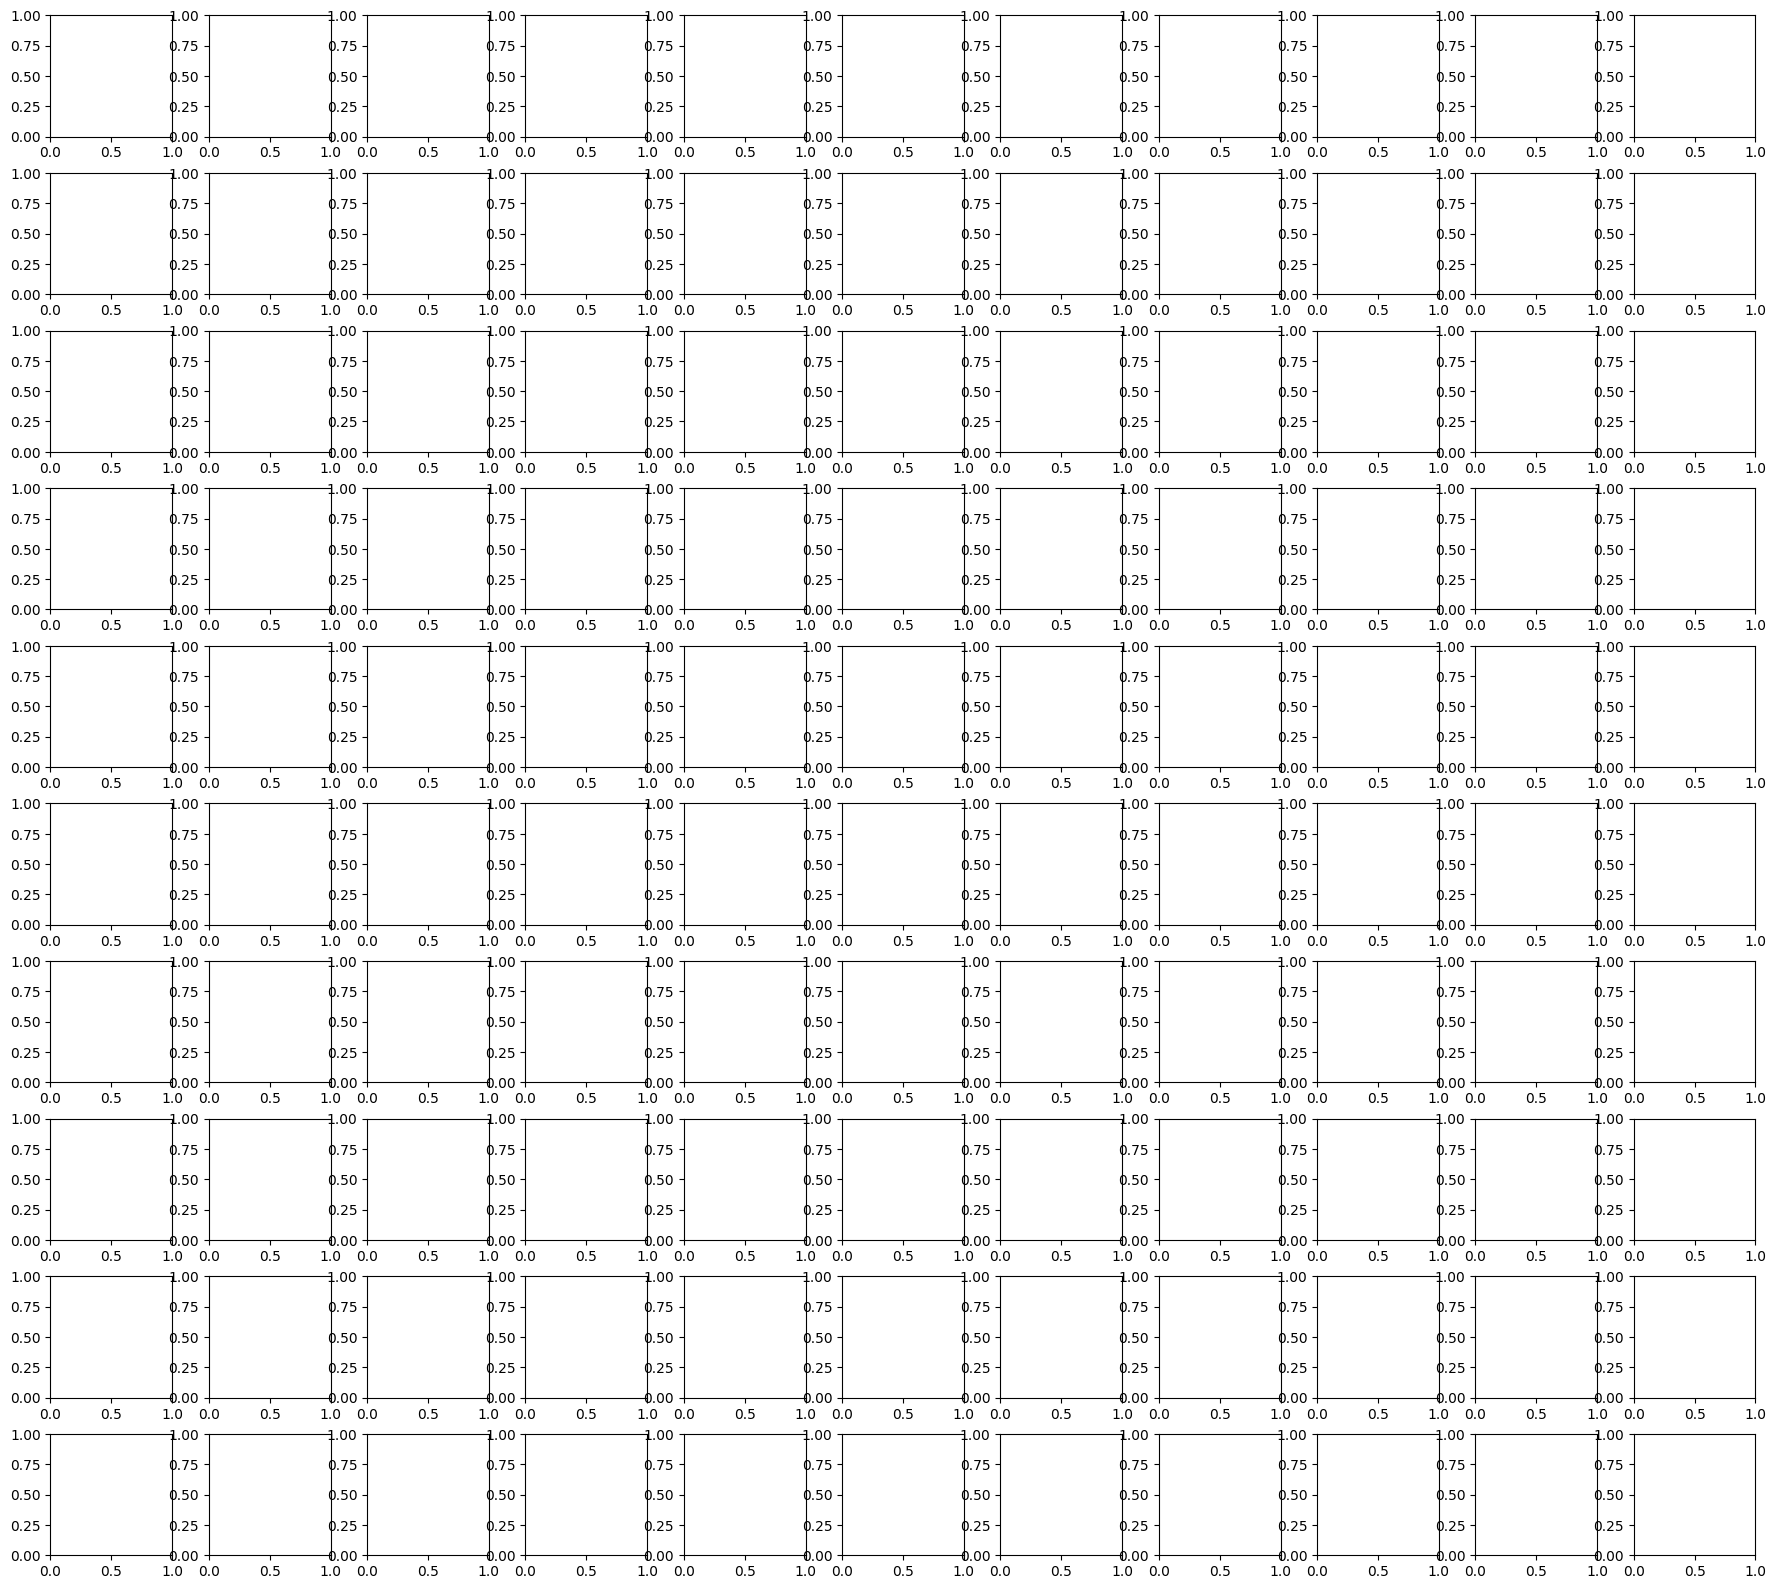

In [150]:
MODEL_CHL_POS = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_POS,
)

##############################################################################
##  Plot dynamics corresponding to predictions (CHL+)

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

MODEL = MODEL_CHL_POS
optimal_alphas = np.load('../out/model_regression/narnir/optimal_alphas_chl_pos.npy')

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)

rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))

inf_param_names = MODEL.get_inferred_param_names()
for native in tqdm.trange(10, desc="native", leave=False):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        # Get LOO predicted parameters
        rA_pred = 0
        rI_pred = 0
        for i in range(len(group_idxs)):
            rA_pred += X_NAR[native, pert, i]*clf_nar.coef_[i]
            rI_pred += X_NIR[native, pert, i]*clf_nir.coef_[i]
        rA_pred += pH_grid[native, pert]*clf_nar.coef_[len(group_idxs)]
        rI_pred += pH_grid[native, pert]*clf_nir.coef_[len(group_idxs)]   
        rA_pred += clf_nar.intercept_
        rI_pred += clf_nir.intercept_
        y_pred = [rA_pred, rI_pred]
        rA_grid[native, pert] = rA_pred
        rI_grid[native, pert] = rI_pred

        # Scaled initial and final enzyme levels
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[9 - native, pert]/scale
        x1_f = nar_t9_none[9 - native, pert]/scale
        x2_f = nir_t9_none[9 - native, pert]/scale
        x3_f = nit_t9_none[9 - native, pert]/scale
        
        # Collect soil samples for the native/perturbed sample
        sample = samples_from_soils(soils[9 - native])[pert]
        
        # Load functional data (CHL+)
        function = get_function(sample, drug="CHL")
        A_data_drug = np.mean(function[0:3,:], axis=0)
        I_data_drug = np.mean(function[3:,:], axis=0)
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        # Plot the inferred model (CHL+)
        y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
        params = {
            p: y_pred[i] for i, p 
            in enumerate(MODEL_CHL_POS.get_inferred_param_names())
        }
        x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)

    
        # Plot metabolites (CHL+)
        ax = axs[native, pert]
        ax.plot(
            plot_t, A, 
            color='navy', alpha=0.5, linewidth=1, 
            label="Model A (CHL+)"
        )
        ax.plot(
            plot_t, I, 
            color='firebrick', alpha=0.5, linewidth=1,
            label="Model I (CHL+)"
        )
        ax.scatter(
            plot_t_scatter, A_data_drug, 
            color='navy', s=10, facecolors='none',
            label="Data A (CHL+)"
        )
        ax.scatter(
            plot_t_scatter, I_data_drug, 
            color='firebrick', s=10, facecolors='none',
            label="Data I (CHL+)"
        )



plt.figure(fig)
plt.show()

In [142]:
print(optimal_alphas)

[0.00868511 0.0355648  0.00339322 0.00686649 0.00542868]


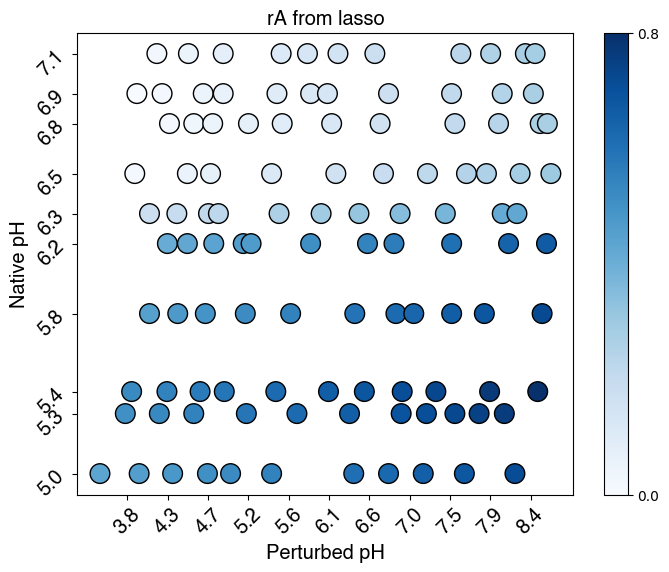

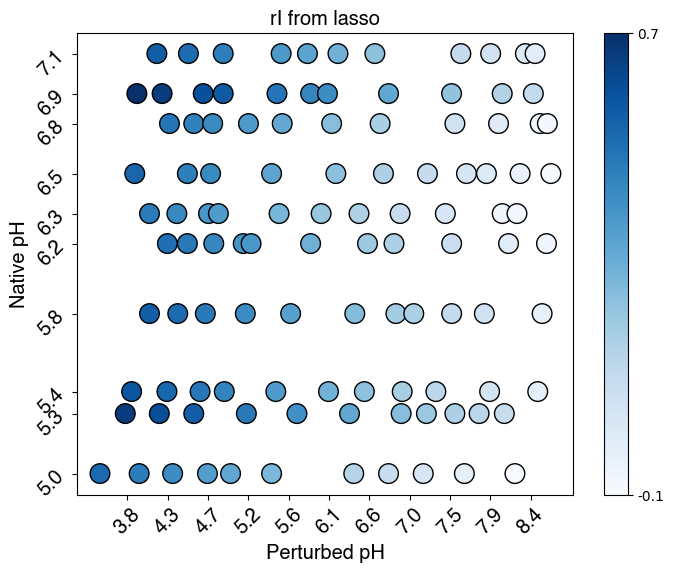

In [121]:
plot(rA_grid, 'rA from lasso')
plot(rI_grid, 'rI from lasso')

# Problem Above: model parameters do not depend linearly on perturbed pH, it is nonlinear. 

So, fit a model for each column instead of incorporating pH directly into the linear regression.

In [135]:
print(f"narG Expression (CHL+) shape: {nar_rel_exp_chl_pos_t0.shape}")
print(f"nirB Expression (CHL+) shape: {nir_rel_exp_chl_pos_t0.shape}")
print(f"Parameters (CHL+) shape: {inferred_params_chl_pos.shape}")
print(f"Parameters (CHL-) shape: {inferred_params_chl_neg.shape}")

print("Reshaping and concatenating...")
X_NAR_CHL_POS = nar_rel_exp_chl_pos_t0
X_NIR_CHL_POS = nir_rel_exp_chl_pos_t0
Y_CHL_POS = inferred_params_chl_pos

narG Expression (CHL+) shape: (10, 11, 7)
nirB Expression (CHL+) shape: (10, 11, 7)
Parameters (CHL+) shape: (10, 11, 2)
Parameters (CHL-) shape: (10, 11, 5)
Reshaping and concatenating...


In [140]:
print(Y_CHL_POS.shape)
print(X_NAR_CHL_POS.shape)

(10, 11, 2)
(10, 11, 7)


In [151]:
##############################################################################
### Lasso for NAR CHL+ case

ALPHA = 0.001  # Regularization strength

clf_nar = []
clf_nir = []
for i in range(11):
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NAR_CHL_POS[:,i,:], Y_CHL_POS[:,i,0])
    clf_nar.append(clf)
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NIR_CHL_POS[:,i,:], Y_CHL_POS[:,i,1])
    clf_nir.append(clf)

print("--------------------------------------------------")
print("CHL+")
for i in range(11):
    print(f"Coefficients {clf_nar[i].coef_.shape}:\n", clf_nar[i].coef_)
    print(f"Intercepts: {clf_nar[i].intercept_.shape}\n", clf_nar[i].intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("CHL-")
print(f"Coefficients {clf_nir[i].coef_.shape}:\n", clf_nir[i].coef_)
print(f"Intercepts: {clf_nir[i].intercept_.shape}\n", clf_nir[i].intercept_)
print("--------------------------------------------------")

--------------------------------------------------
CHL+
Coefficients (7,):
 [-0.09065676  0.          0.03450726 -0.          0.          0.
  0.        ]
Intercepts: ()
 0.16066413507069083
Coefficients (7,):
 [-0.06367722  0.          0.          0.11633613  0.          0.
 -0.        ]
Intercepts: ()
 0.21457001819217553
Coefficients (7,):
 [-0.13958486  0.         -0.          0.12541345  0.          0.
  0.        ]
Intercepts: ()
 0.32303519158028493
Coefficients (7,):
 [-0.20107373  0.         -0.18768713  0.41715004  0.          0.
  0.06764952]
Intercepts: ()
 0.37225611082419136
Coefficients (7,):
 [-0.30375174  0.         -0.23493595  0.71083284  0.          0.
  0.04737136]
Intercepts: ()
 0.47350554664676314
Coefficients (7,):
 [-0.46472897  0.         -0.          0.68920248  0.          0.
  0.        ]
Intercepts: ()
 0.628173131709566
Coefficients (7,):
 [-0.64837302  0.          0.          1.55603037  0.          0.
 -0.20170583]
Intercepts: ()
 0.7946784755317685
Co

Generate rA and rI matrix

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

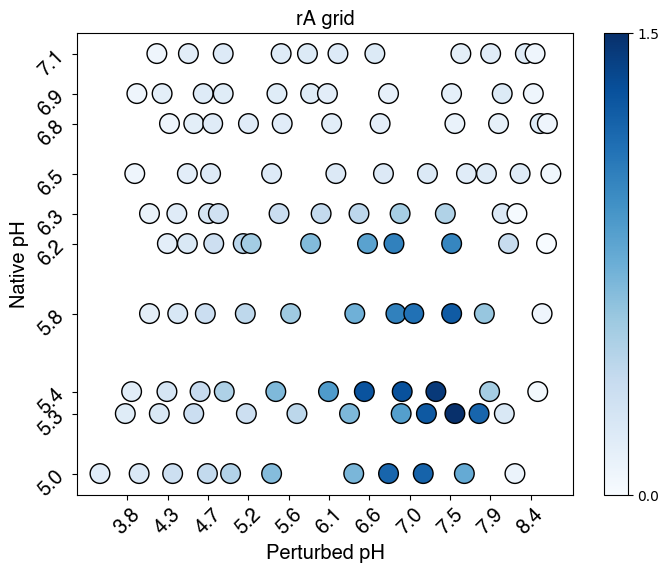

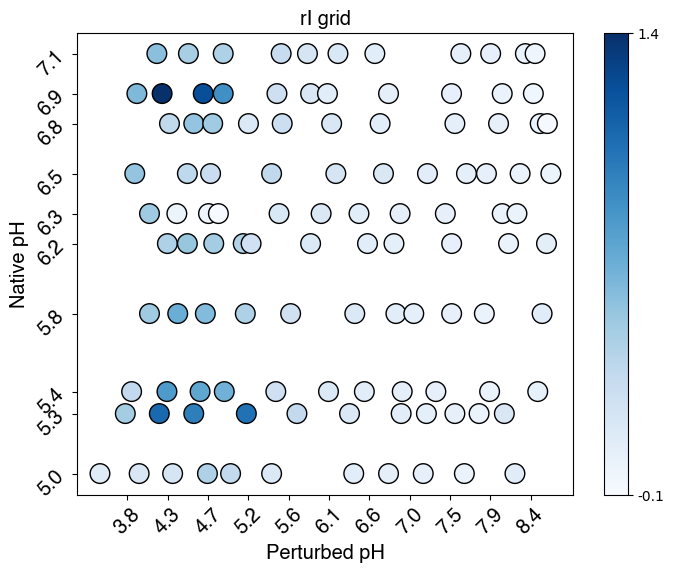

In [157]:
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR = nir_rel_exp_chl_pos_t0
X_NAR = nar_rel_exp_chl_pos_t0
for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            rA_pred = 0
            rI_pred = 0
            for i in range(len(group_idxs)):
                rA_pred += X_NAR[native, pert, i]*clf_nar[pert].coef_[i]
                rI_pred += X_NIR[native, pert, i]*clf_nir[pert].coef_[i]  
            rA_pred += clf_nar[pert].intercept_
            rI_pred += clf_nir[pert].intercept_
            y_pred = [rA_pred, rI_pred]
            rA_grid[native, pert] = rA_pred
            rI_grid[native, pert] = rI_pred

plot(rA_grid, 'rA grid')
plot(rI_grid, 'rI grid')


Now plot with this new grid

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

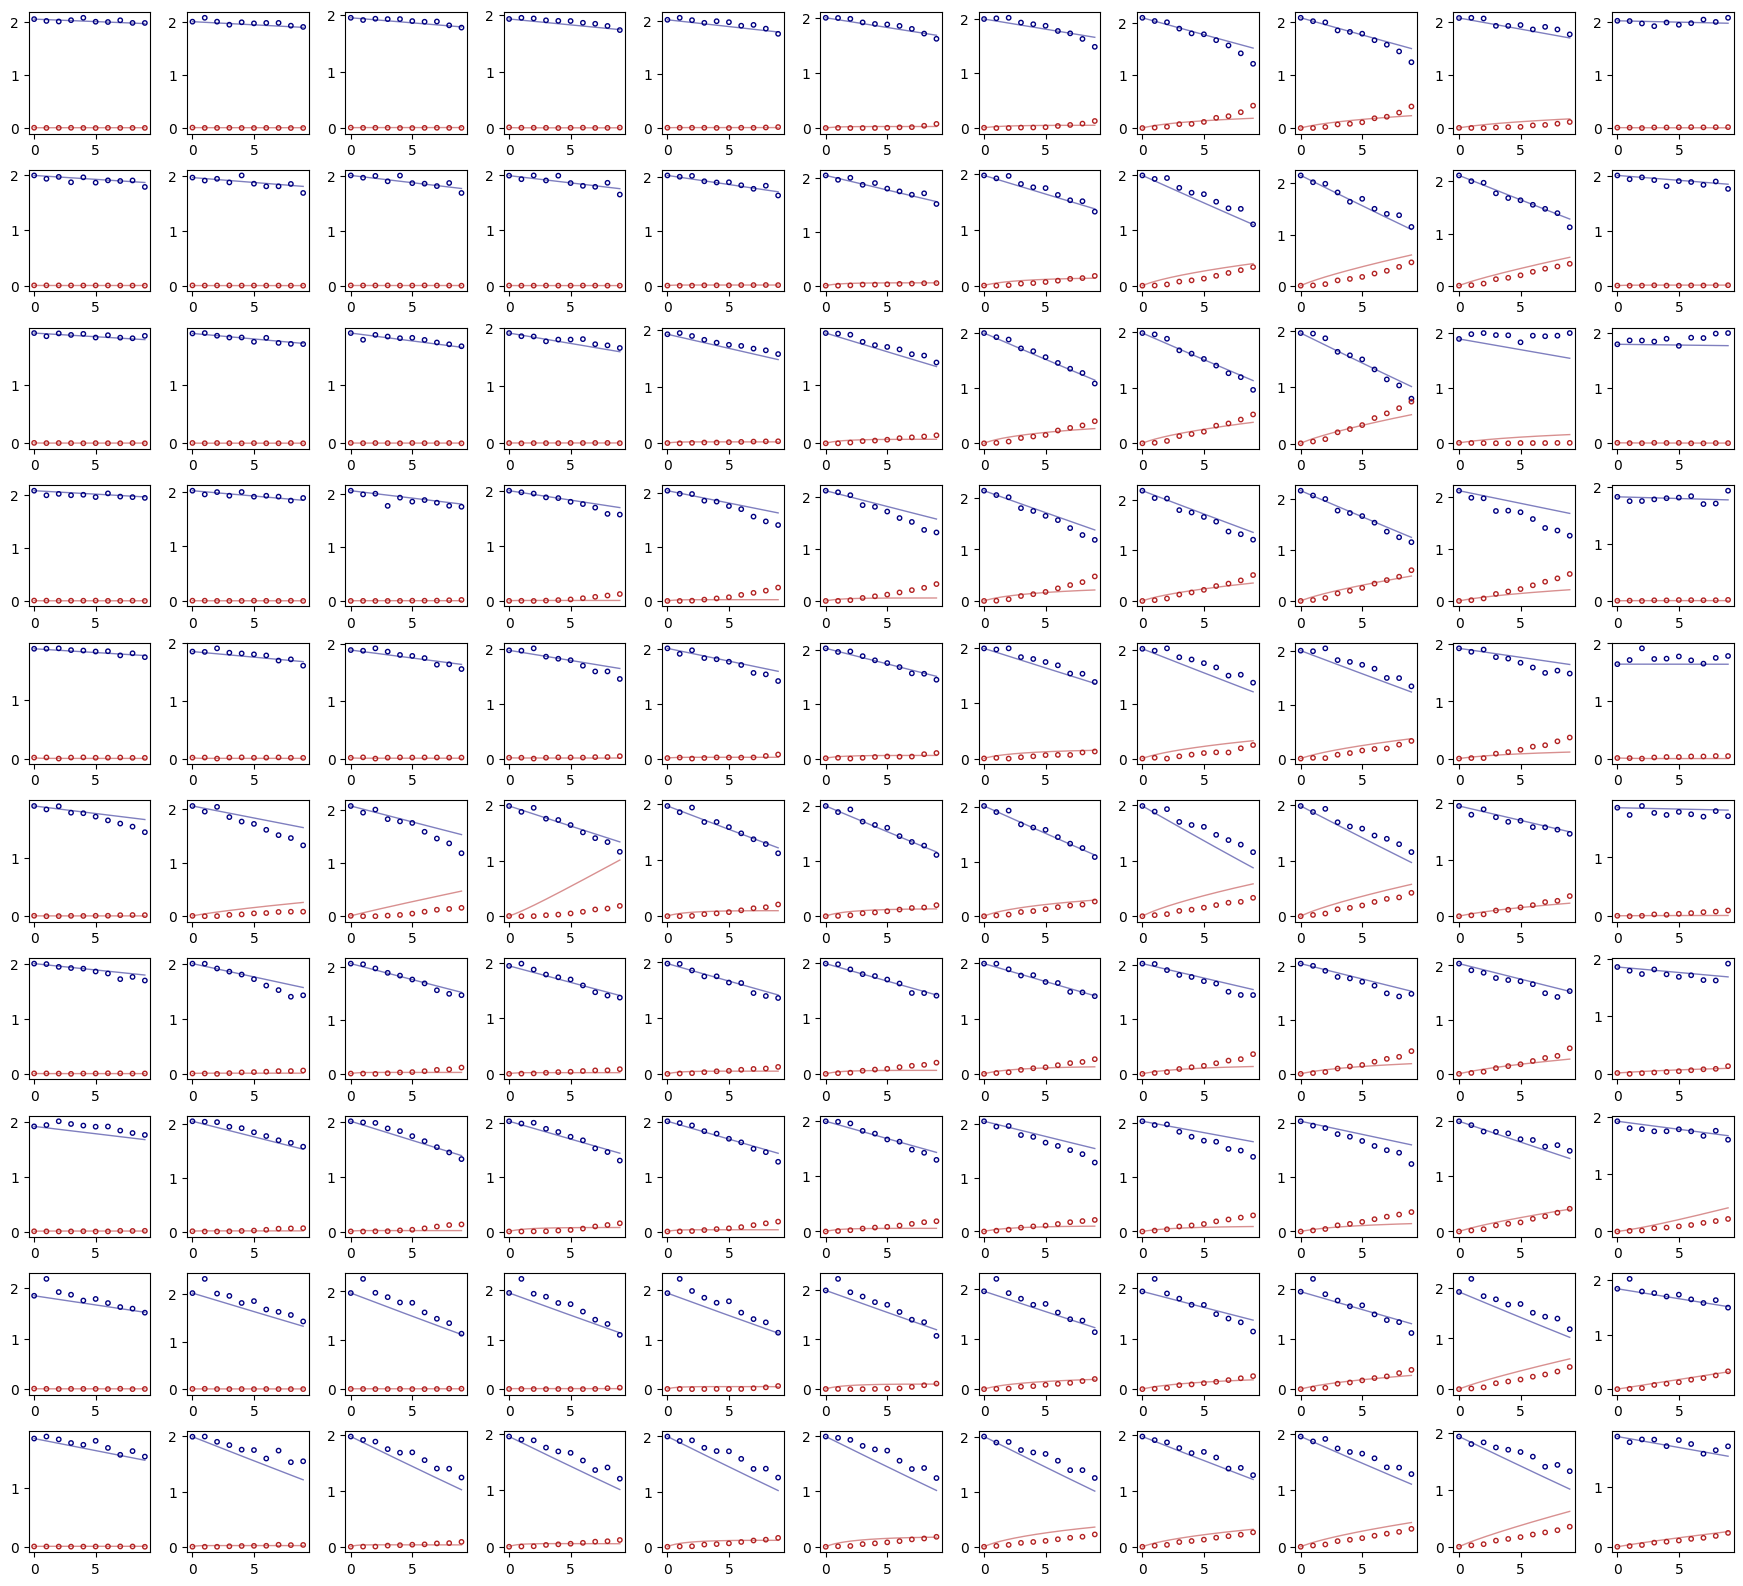

In [159]:
MODEL_CHL_POS = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_POS,
)

##############################################################################
##  Plot dynamics corresponding to predictions (CHL+)

fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

MODEL = MODEL_CHL_POS

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)

inf_param_names = MODEL.get_inferred_param_names()
for native in tqdm.trange(10, desc="native", leave=False):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        
        rA_pred = rA_grid[native, pert]
        rI_pred = rI_grid[native, pert]
        y_pred = [rA_pred, rI_pred]

        # Scaled initial and final enzyme levels
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[9 - native, pert]/scale
        x1_f = nar_t9_none[9 - native, pert]/scale
        x2_f = nir_t9_none[9 - native, pert]/scale
        x3_f = nit_t9_none[9 - native, pert]/scale
        
        # Collect soil samples for the native/perturbed sample
        sample = samples_from_soils(soils[9 - native])[pert]
        
        # Load functional data (CHL+)
        function = get_function(sample, drug="CHL")
        A_data_drug = np.mean(function[0:3,:], axis=0)
        I_data_drug = np.mean(function[3:,:], axis=0)
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        # Plot the inferred model (CHL+)
        y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
        params = {
            p: y_pred[i] for i, p 
            in enumerate(MODEL_CHL_POS.get_inferred_param_names())
        }
        x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)

    
        # Plot metabolites (CHL+)
        ax = axs[native, pert]
        ax.plot(
            plot_t, A, 
            color='navy', alpha=0.5, linewidth=1, 
            label="Model A (CHL+)"
        )
        ax.plot(
            plot_t, I, 
            color='firebrick', alpha=0.5, linewidth=1,
            label="Model I (CHL+)"
        )
        ax.scatter(
            plot_t_scatter, A_data_drug, 
            color='navy', s=10, facecolors='none',
            label="Data A (CHL+)"
        )
        ax.scatter(
            plot_t_scatter, I_data_drug, 
            color='firebrick', s=10, facecolors='none',
            label="Data I (CHL+)"
        )



plt.figure(fig)
plt.show()